In [ ]:
device='cuda'

## Import Packages

In [ ]:
from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.distributions.kl import kl_divergence
from torchvision import datasets, transforms
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from tqdm import tqdm
from google.colab import userdata
import os
import json
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import torchvision
from transformers import BertTokenizer
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

## Download COCO API

In [ ]:
!git clone https://github.com/cocodataset/cocoapi.git

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 10.43 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [ ]:
cd cocoapi/PythonAPI

/content/cocoapi/PythonAPI


In [ ]:
!pwd

/content/cocoapi/PythonAPI


In [ ]:
!make

python setup.py build_ext --inplace
running build_ext
Compiling pycocotools/_mask.pyx because it changed.
[1/1] Cythonizing pycocotools/_mask.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-cpython-310
creating build/temp.linux-x86_64-cpython-310/pycocotools
x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/local/lib/python3.10/dist-packages/numpy/core/include -I../common -I/usr/include/python3.10 -c ../common/maskApi.c -o build/temp.linux-x86_64-cpython-310/../common/maskApi.o -Wno-cpp -Wno-unused-funct

## Download dataset and preprocess it

In [ ]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d awsaf49/coco-2017-dataset

Dataset URL: https://www.kaggle.com/datasets/awsaf49/coco-2017-dataset
License(s): CC-BY-SA-4.0
100% 25.0G/25.0G [22:21<00:00, 22.6MB/s]
100% 25.0G/25.0G [22:22<00:00, 20.0MB/s]


In [ ]:
!mkdir -p /content/Dataset

In [ ]:
!unzip "coco-2017-dataset" -d "/content/Dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/coco2017/val2017/000000000139.jpg  
  inflating: /content/Dataset/coco2017/val2017/000000000285.jpg  
  inflating: /content/Dataset/coco2017/val2017/000000000632.jpg  
  inflating: /content/Dataset/coco2017/val2017/000000000724.jpg  
  inflating: /content/Dataset/coco2017/val2017/000000000776.jpg  
  inflating: /content/Dataset/coco2017/val2017/000000000785.jpg  
  inflating: /content/Dataset/coco2017/val2017/000000000802.jpg  
  inflating: /content/Dataset/coco2017/val2017/000000000872.jpg  
  inflating: /content/Dataset/coco2017/val2017/000000000885.jpg  
  inflating: /content/Dataset/coco2017/val2017/000000001000.jpg  
  inflating: /content/Dataset/coco2017/val2017/000000001268.jpg  
  inflating: /content/Dataset/coco2017/val2017/000000001296.jpg  
  inflating: /content/Dataset/coco2017/val2017/000000001353.jpg  
  inflating: /content/Dataset/coco2017/val2017/000000001425.jpg  
  inflating: /content/Dat

In [ ]:
os.listdir('/content/Dataset/coco2017/annotations')

['captions_val2017.json',
 'person_keypoints_val2017.json',
 'instances_train2017.json',
 'captions_train2017.json',
 'person_keypoints_train2017.json',
 'instances_val2017.json']

In [ ]:
import torch
from torchvision.models import vit_b_32, ViT_B_32_Weights
weights = ViT_B_32_Weights.DEFAULT
encoder = vit_b_32(weights=weights)
encoder.heads = torch.nn.Identity()
encoder = encoder.cpu()
preprocess = weights.transforms()


# freezinf model weights
for param in encoder.parameters():
  param.requires_grad = False



def process_image(img):
  ''' Takes (1, 3, 224, 224) and outputs (1, 32, 768)
  '''
  img_tensor = torch.unsqueeze(img, 0)
  output = encoder(img_tensor)
  output = output.repeat(32, 1)
  return output

In [ ]:
dataset = dset.CocoCaptions(root = '/content/Dataset/coco2017/train2017',
                        annFile = '/content/Dataset/coco2017/annotations/captions_train2017.json',
                        transform=preprocess)

loading annotations into memory...
Done (t=0.87s)
creating index...
index created!


In [ ]:
img, target = dataset[3] # load 4th sample

print("Image Size: ", img.size())
print(target)

Image Size:  torch.Size([3, 224, 224])
['A zebra grazing on lush green grass in a field.', 'Zebra reaching its head down to ground where grass is. ', 'The zebra is eating grass in the sun.', 'A lone zebra grazing in some green grass.', 'a Zebra grazing on grass in a green open field.']


In [ ]:
from transformers import BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_and_pad(text_list, max_length):
    tokenized_texts = [tokenizer.encode(text, max_length=max_length, truncation=True, padding='max_length') for text in text_list]
    tokenized_tensors = torch.tensor(tokenized_texts, dtype=torch.int64)
    padding_tensor = torch.tensor([[tokenizer.pad_token_id]] * tokenized_tensors.size(0), dtype=torch.int64)
    shifted_tensors = torch.cat([tokenized_tensors[:, 1:], padding_tensor], dim=1)
    return (tokenized_tensors[:5, :], shifted_tensors[:5, :])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class ModifiedCocoCaptions(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        img, captions = self.dataset[index]
        # Peprocess image
        resize_transform = transforms.Resize((224, 224))
        img = resize_transform(img)
        image_embedding = process_image(img)


        # Preprocess txt
        tokenized_caption = tokenize_and_pad(captions, 32)
        return (img, image_embedding), tokenized_caption

    def __len__(self):
        return len(self.dataset)

modified_dataset = ModifiedCocoCaptions(dataset)

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import random_split

total_count = len(modified_dataset)
train_count = int(0.95 * total_count)
val_count = total_count - train_count

# Use random_split to create train and validation subsets
train_modified_dataset, val_modified_dataset = random_split(modified_dataset, [train_count, val_count])

In [ ]:
train_data_loader = DataLoader(train_modified_dataset, batch_size=32, shuffle=True)
val_data_loader = DataLoader(val_modified_dataset, batch_size=32, shuffle=True)

In [ ]:
print(len(train_data_loader))
print(len(val_data_loader))

3512
185


In [ ]:
for example in train_data_loader:
  image_data, txts = example
  original_img, img_embeddings = image_data
  print(img_embeddings.shape)
  break

torch.Size([32, 32, 768])


## Create Model

In [ ]:
def create_positional_encoding(max_length, d_model):
    assert d_model % 2 == 0, "Dimension model must be even"

    pos = torch.arange(0, max_length).unsqueeze(1) # (max_length, 1)
    '''
    pos_expanded = [
      0, 0, 0, ... 0
      1, 1, 1, ... 1
      2, 2, 2, ... 2
      3, 3, 3, ... 3
      .
      .
      .
      max_length-1, ... max_length -1
    ]
    '''
    pos_expanded = pos.repeat(1, d_model // 2) # (max_length, d_model // 2)

    power = torch.arange(0, d_model, 2).float() / d_model
    div_term = torch.pow(10000, power).unsqueeze(0) # (1, d_model // 2)
    div_term_expanded = div_term.repeat(max_length, 1)  # (max_length, d_model // 2)

    pe = torch.zeros(max_length, d_model) # (max_length, d_model)
    pe[:, 0::2] = torch.sin(pos_expanded / div_term_expanded) # (max_length, d_model // 2)
    pe[:, 1::2] = torch.cos(pos_expanded / div_term_expanded) # (max_length, d_model // 2)

    return pe

In [ ]:
class Embedding(nn.Module):
  def __init__(self, vocab_size, max_length, d_model):
    super(Embedding, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model)
    self.pos_encoding = create_positional_encoding(max_length, d_model).to(device)

  def forward(self, x):
    """ Apply embedding and positional encoding to the input

    Input:
      x: (N, seq_length)
    Output:
      x: (N, seq_length, d_model)
    """
    # apply embedding
    x = self.embedding(x)
    # apply positional encoding
    x += self.pos_encoding[:x.size(1)]
    return x

In [ ]:
mask_size = 32
causal_mask = torch.zeros(mask_size, mask_size)
for i in range(mask_size):
    for j in range(mask_size):
        if i < j:
            causal_mask[i, j] = float('-inf')


causal_mask = causal_mask.to(device)
print(causal_mask)

tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


In [ ]:
class CausalSelfAttention(nn.Module):
  def __init__(self, d_model, num_heads, dropout):
    super(CausalSelfAttention, self).__init__()
    self.mha = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout, batch_first=True)
    self.layer_norm = nn.LayerNorm(d_model)


  def forward(self, x):
    attn_output, _ = self.mha(query=x, key=x, value=x, attn_mask=causal_mask, is_causal=True)
    x = self.layer_norm(x + attn_output)
    return x

In [ ]:
class CrossAttention(nn.Module):
  def __init__(self, d_model, num_heads, dropout):
    super(CrossAttention, self).__init__()
    self.mha = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout, batch_first=True)
    self.layer_norm = nn.LayerNorm(d_model)


  def forward(self, x, image_embedding):
    attn_output, _ = self.mha(query=x, key=image_embedding, value=image_embedding)
    x = self.layer_norm(x + attn_output)
    return x

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, d_model, dropout):
    super(FeedForward, self).__init__()
    self.seq = nn.ModuleList([
        nn.Linear(d_model, 2 * d_model),
        nn.ReLU(),
        nn.Linear(2 * d_model, d_model),
        nn.Dropout(dropout)
    ])

    self.layernorm = nn.LayerNorm(d_model)

  def forward(self, x):
    original_x = x
    for layer in self.seq:
      x = layer(x)
    out = x + original_x
    return self.layernorm(out)

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, dropout):
    super(DecoderLayer, self).__init__()
    self.self_attention = CausalSelfAttention(d_model=d_model, num_heads=num_heads, dropout=dropout)
    self.cross_attention = CrossAttention(d_model=d_model, num_heads=num_heads, dropout=dropout)
    self.ff = FeedForward(d_model=d_model, dropout=dropout)

  def forward(self, inputs):
    x, image_embedding = inputs
    x = self.self_attention(x)
    x = self.cross_attention(x, image_embedding)
    x = self.ff(x)
    return x

In [ ]:
class Lastlayer(nn.Module):
  def __init__(self, units, vocab_size):
    super(Lastlayer, self).__init__()
    self.linear = nn.Linear(units, vocab_size)

  def forward(self, x):
    x = self.linear(x)
    return x

In [ ]:
class Captioner(nn.Module):
  def __init__(self, vocab_size, max_length, d_model, num_heads, num_layers, dropout):
    super(Captioner, self).__init__()
    self.seq_embedding = Embedding(vocab_size, max_length, d_model)
    self.decoder_layers = nn.ModuleList([
    DecoderLayer(d_model, num_heads, dropout) for _ in range(num_layers)
    ])
    self.last_layer = Lastlayer(d_model, vocab_size)

    self.linear = nn.Linear(768, d_model)

  def forward(self, image_embeddings, txt):
    """
    inputs:
      txt: (N, max_length)
      image_embeddings: (N, 7, 7, 576)
    """
    x = self.seq_embedding(txt) # x: (N, max_length, d_model)
    # transform image_embeddings to proper shape
    image_embeddings = self.linear(image_embeddings)

    for dec_layer in self.decoder_layers:
      x = dec_layer((x, image_embeddings))

    # x: (N, max_length, units)

    x = self.last_layer(x) # (N, max_length, vocab_size)

    return x

In [ ]:
model = Captioner(vocab_size = tokenizer.vocab_size, max_length = 32, d_model = 512, num_heads = 8, num_layers=4, dropout = 0.4)

In [ ]:
model = model.to(device)

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 44296506


In [ ]:
random_txt = torch.randint(low=0, high=tokenizer.vocab_size, size=(1, 32), device=device)
random_image_embedding = torch.randn((1, 32, 768), device=device)

output = model(random_image_embedding, random_txt)

print(output.shape)

torch.Size([1, 32, 30522])


**Inputs:**

image_embeddings: (N, 32, 786)

txt: (N, max_length)


**Output:**

(N, max_length, vocab_size)

## Train

In [ ]:
def masked_loss(labels, preds):
  '''
  Inputs:
    labels: (N, seq_length)
    preds: (N, seq_length, d_model)
  '''
  loss = F.cross_entropy(preds.transpose(1, 2), labels, reduction='none')
  mask = (labels != 0) & torch.isfinite(loss)
  masked_loss = loss * mask.float()
  average_loss = masked_loss.sum() / (mask.float().sum() + 1e-10)
  return average_loss

In [ ]:
def masked_accuracy(labels, preds):
  '''
  Inputs:
    labels: (N, seq_length)
    preds: (N, seq_length, vocab_size)
  '''
  mask = labels != 0
  pred_labels = torch.argmax(preds, axis=-1)
  correct_predictions = (pred_labels == labels) & mask

  num_correct = correct_predictions.sum()
  total_masked = mask.sum()

  if total_masked == 0:
    return 0.0

  accuracy = num_correct / total_masked
  return accuracy

In [ ]:
import torch.optim as optim
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
import matplotlib.pyplot as plt
import torch

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu()
    inp = inp.view(3, 224, 224)
    inp = inp.numpy().transpose((1, 2, 0))  # Convert to HxWxC format
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)  # Clip values to be between 0 and 1 to display

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [ ]:
def sample_generation(original_image, image_embedding, model):
  txt = torch.zeros(1, 32)
  txt[0][0] = 101
  txt = txt.type(torch.int64).to(device)
  max_length=32

  for i in range(max_length-1):
    logit = model(image_embedding, txt) # (1, seq_length, vocab_size)
    pred = logit[:, i, :] # (1, vocab_size)
    pred = F.softmax(pred, dim=-1)  # (1, vocab_size)
    next_word_index = pred.argmax(dim=-1)
    # print(f"next word: {next_word_index.item()}")

    if next_word_index.item() == 102:
      break

    txt[0][i+1] = next_word_index.item()


  # decode the tokenized array to String
  decoded_string = [tokenizer.decode(txt[0])][0]
  imshow(original_image)
  print(decoded_string)

In [ ]:
def evaluate_validation(model):
  model.eval()
  total_loss = 0
  total_accuracy = 0
  total_size = len(val_data_loader)
  stop = 20

  for batch_idx, (image_data, txts) in enumerate(tqdm(val_data_loader)):
    txt_index = 0
    original_images, image_embeddings = image_data
    image_embeddings = image_embeddings.to(device)
    image_input = image_embeddings
    txt_input = txts[0][:, txt_index, :].to(device)
    txt_output = txts[1][:, txt_index, :].to(device)

    pred = model(image_input, txt_input)
    loss = masked_loss(txt_output, pred)
    accuracy = masked_accuracy(txt_output, pred)

    total_loss += loss / stop
    total_accuracy += accuracy / stop

    if batch_idx == stop:
      break


  return total_loss, total_accuracy

In [ ]:
def train_one_epoch(epoch):
  model.train()
  total_train_size = len(train_data_loader)
  total_train_loss = 0
  total_train_accuracy = 0
  for batch_idx, (image_data, txts) in enumerate(tqdm(train_data_loader)):
    txt_index = epoch%5
    original_images, image_embeddings = image_data
    image_embeddings = image_embeddings.to(device)
    image_input = image_embeddings
    txt_input = txts[0][:, txt_index, :].to(device)
    txt_output = txts[1][:, txt_index, :].to(device)

    optimizer.zero_grad()
    pred = model(image_input, txt_input)
    loss = masked_loss(txt_output, pred)
    loss.backward()
    optimizer.step()

    accuracy = masked_accuracy(txt_output, pred)

    total_train_loss+=loss.item()/total_train_size
    total_train_accuracy+=accuracy.item()/total_train_size

    if batch_idx % 300 == 0 and batch_idx != 0:
      print(f"batch {batch_idx} \| train_masked_loss: {loss}, train_masked_accuracy: {accuracy}")

      checkpoint_path = f"/content/checkpoints/checkpoint_epoch_{epoch}_batch_{batch_idx}.pth"
      torch.save({
          'epoch': epoch,
          'batch_idx': batch_idx,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': loss,
          'accuracy': accuracy
      }, checkpoint_path)
      print(f"Saved checkpoint to {checkpoint_path}")

      random_index = torch.randint(0, 32, (1,))
      sample_image_embedding = image_embeddings[random_index].to(device)
      sample_original_image = original_images[random_index]

      sample_generation(sample_original_image, sample_image_embedding, model)

  # after epoch ends prints out the validation accuracy too
  # val_masked_loss, val_masked_accuracy = evaluate_validation()
  print(f"Epoch-{epoch} ended")
  # print(f"train_masekd_loss: {val_masked_loss}, train_masked_accuracy: {val_masked_accuracy}")
  # print(f"val_masekd_loss: {total_train_loss}, val_masked_accuracy: {total_train_accuracy}")

  9%|▊         | 300/3512 [11:03<1:58:43,  2.22s/it]

batch 300 \| train_masked_loss: 4.119235515594482, train_masked_accuracy: 0.36626505851745605
Saved checkpoint to /content/checkpoints/checkpoint_epoch_0_batch_300.pth


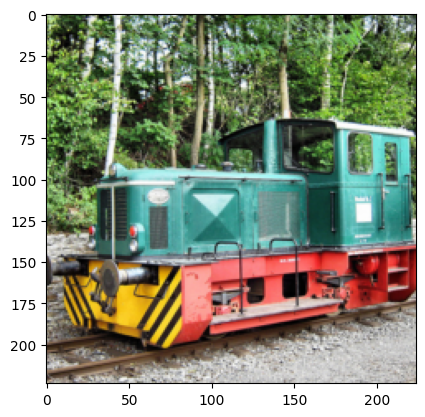

  9%|▊         | 301/3512 [11:07<2:18:03,  2.58s/it]

[CLS] a train is sitting on a train on a train. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


 17%|█▋        | 600/3512 [22:10<1:51:05,  2.29s/it]

batch 600 \| train_masked_loss: 3.1950807571411133, train_masked_accuracy: 0.43989768624305725
Saved checkpoint to /content/checkpoints/checkpoint_epoch_0_batch_600.pth


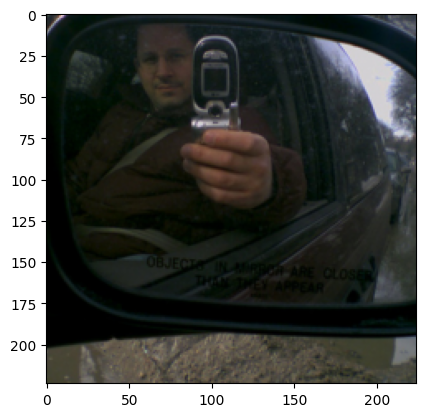

 17%|█▋        | 601/3512 [22:13<2:07:43,  2.63s/it]

[CLS] a man sitting on a table with a dog in a field. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


 26%|██▌       | 900/3512 [33:16<1:41:25,  2.33s/it]

batch 900 \| train_masked_loss: 3.163147449493408, train_masked_accuracy: 0.40897756814956665
Saved checkpoint to /content/checkpoints/checkpoint_epoch_0_batch_900.pth


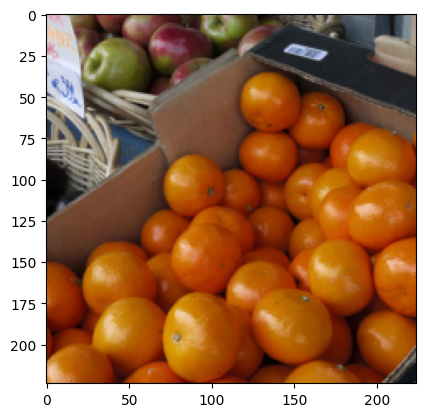

 26%|██▌       | 901/3512 [33:19<1:55:55,  2.66s/it]

[CLS] a white bowl filled with a table and a table. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


 34%|███▍      | 1200/3512 [44:21<1:27:04,  2.26s/it]

batch 1200 \| train_masked_loss: 3.2021570205688477, train_masked_accuracy: 0.4146919548511505
Saved checkpoint to /content/checkpoints/checkpoint_epoch_0_batch_1200.pth


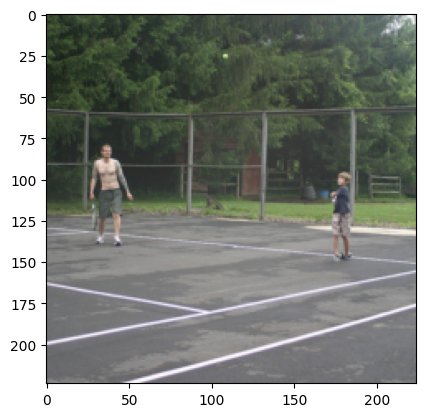

 34%|███▍      | 1201/3512 [44:25<1:40:32,  2.61s/it]

[CLS] a man riding a skateboard on a tennis court. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


 43%|████▎     | 1500/3512 [55:25<1:12:18,  2.16s/it]

batch 1500 \| train_masked_loss: 2.981966495513916, train_masked_accuracy: 0.41809290647506714
Saved checkpoint to /content/checkpoints/checkpoint_epoch_0_batch_1500.pth


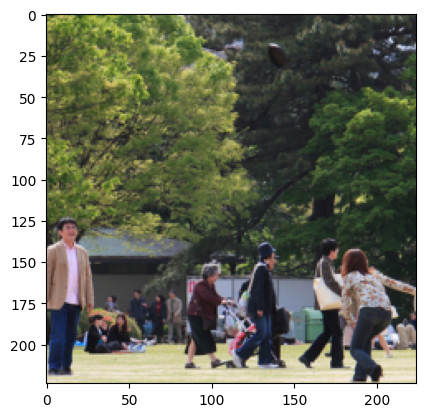

 43%|████▎     | 1501/3512 [55:29<1:30:38,  2.70s/it]

[CLS] a group of people standing on a field with a frisbee. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


 51%|█████▏    | 1800/3512 [1:06:34<1:06:54,  2.34s/it]

batch 1800 \| train_masked_loss: 2.9947032928466797, train_masked_accuracy: 0.4637681245803833
Saved checkpoint to /content/checkpoints/checkpoint_epoch_0_batch_1800.pth


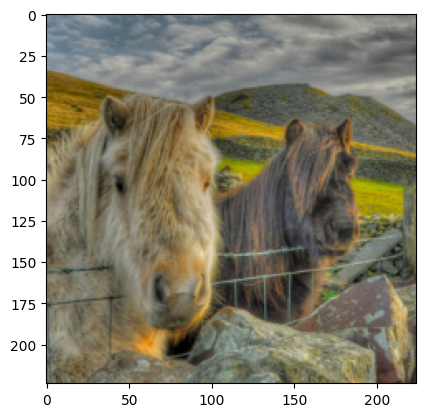

 51%|█████▏    | 1801/3512 [1:06:38<1:16:06,  2.67s/it]

[CLS] a brown and white cat sitting on top of a bench. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


 60%|█████▉    | 2100/3512 [1:17:38<48:18,  2.05s/it]

batch 2100 \| train_masked_loss: 3.220249652862549, train_masked_accuracy: 0.39294710755348206
Saved checkpoint to /content/checkpoints/checkpoint_epoch_0_batch_2100.pth


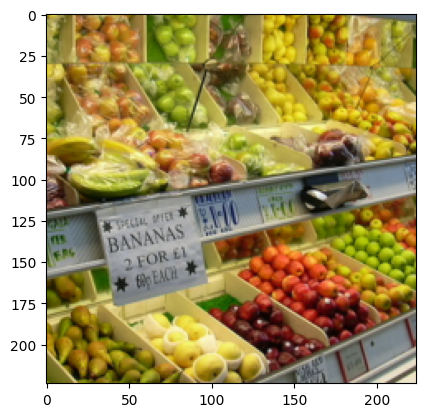

 60%|█████▉    | 2101/3512 [1:17:41<57:02,  2.43s/it]

[CLS] a bunch of fruit of fruit and bananas on a table [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


 68%|██████▊   | 2400/3512 [1:28:11<37:55,  2.05s/it]

batch 2400 \| train_masked_loss: 2.356907844543457, train_masked_accuracy: 0.530927836894989
Saved checkpoint to /content/checkpoints/checkpoint_epoch_0_batch_2400.pth


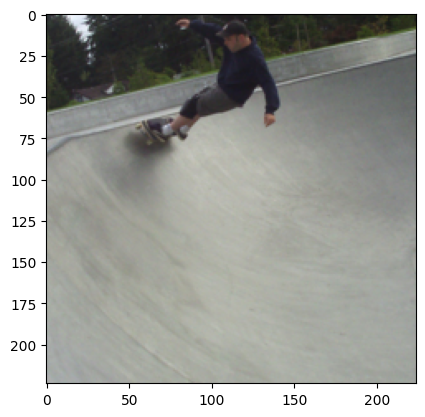

 68%|██████▊   | 2401/3512 [1:28:15<46:09,  2.49s/it]

[CLS] a man riding a skateboard down a ramp. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


 77%|███████▋  | 2700/3512 [1:38:48<28:07,  2.08s/it]

batch 2700 \| train_masked_loss: 2.970705032348633, train_masked_accuracy: 0.4285714328289032
Saved checkpoint to /content/checkpoints/checkpoint_epoch_0_batch_2700.pth


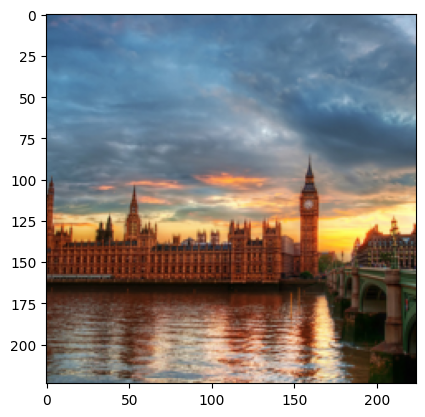

 77%|███████▋  | 2701/3512 [1:38:51<33:02,  2.44s/it]

[CLS] a large building with a clock on the side of it. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


 85%|████████▌ | 3000/3512 [1:49:22<18:06,  2.12s/it]

batch 3000 \| train_masked_loss: 2.973390579223633, train_masked_accuracy: 0.4424999952316284
Saved checkpoint to /content/checkpoints/checkpoint_epoch_0_batch_3000.pth


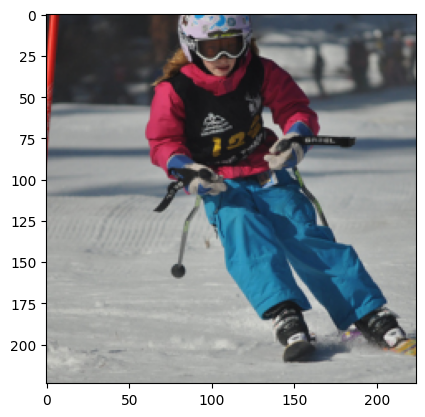

 85%|████████▌ | 3001/3512 [1:49:26<21:43,  2.55s/it]

[CLS] a man riding skis down a snow covered slope. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


 94%|█████████▍| 3300/3512 [1:59:57<07:28,  2.12s/it]

batch 3300 \| train_masked_loss: 2.6345326900482178, train_masked_accuracy: 0.47999998927116394
Saved checkpoint to /content/checkpoints/checkpoint_epoch_0_batch_3300.pth


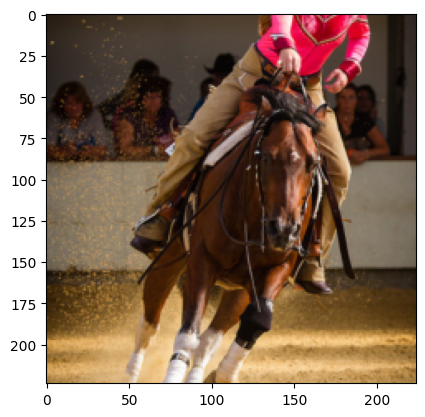

 94%|█████████▍| 3301/3512 [2:00:00<08:45,  2.49s/it]

[CLS] a woman riding a horse in a dirt field. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


100%|██████████| 3512/3512 [2:07:28<00:00,  2.18s/it]

Epoch-0 ended


In [ ]:
# NOW let's train our model!
for epoch in range(1):
  train_one_epoch(epoch)

In [ ]:
def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    batch_idx = checkpoint['batch_idx']
    loss = checkpoint['loss']
    accuracy = checkpoint['accuracy']

    print(f"Loaded checkpoint from epoch {epoch}, batch {batch_idx} with loss {loss} and accuracy {accuracy}.")
    return model, optimizer, epoch, batch_idx, loss, accuracy

Check val_masked_accuracy and val_masked_loss for some checkpoints

In [ ]:
checkpoint_path = '/content/checkpoints/checkpoint_epoch_0_batch_2400.pth'
batch2400_model, optimizer, epoch, batch_idx, loss, accuracy = load_checkpoint(model, optimizer, checkpoint_path)

Loaded checkpoint from epoch 0, batch 2400 with loss 2.356907844543457 and accuracy 0.530927836894989.


In [ ]:
evaluate_validation(batch2400_model)

 11%|█         | 20/185 [00:44<06:11,  2.25s/it]


(tensor(2.7901, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.5102, device='cuda:0'))

In [ ]:
checkpoint_path = '/content/checkpoints/checkpoint_epoch_0_batch_2700.pth'
batch2700_model, optimizer, epoch, batch_idx, loss, accuracy = load_checkpoint(model, optimizer, checkpoint_path)
evaluate_validation(batch2700_model)

Loaded checkpoint from epoch 0, batch 2700 with loss 2.970705032348633 and accuracy 0.4285714328289032.


 11%|█         | 20/185 [00:44<06:03,  2.20s/it]


(tensor(2.8251, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.5080, device='cuda:0'))

In [ ]:
checkpoint_path = '/content/checkpoints/checkpoint_epoch_0_batch_3000.pth'
batch3000_model, optimizer, epoch, batch_idx, loss, accuracy = load_checkpoint(model, optimizer, checkpoint_path)
evaluate_validation(batch3000_model)

Loaded checkpoint from epoch 0, batch 3000 with loss 2.973390579223633 and accuracy 0.4424999952316284.


 11%|█         | 20/185 [00:44<06:11,  2.25s/it]


(tensor(2.8451, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.5031, device='cuda:0'))

In [ ]:
evaluate_validation(model)

 11%|█         | 20/185 [00:45<06:13,  2.26s/it]


(tensor(2.8519, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.5028, device='cuda:0'))

## Sample inference

In [ ]:
from PIL import Image

def example_generation(original_image_url, model):
  txt = torch.zeros(1, 32)
  txt[0][0] = 101
  txt = txt.type(torch.int64).to(device)
  max_length=32

  for i in range(max_length-1):
    # do preprocess of image
    image = Image.open(original_image_url).convert('RGB')

    weights = ViT_B_32_Weights.DEFAULT
    preprocess = weights.transforms()
    image = torchvision.transforms.functional.pil_to_tensor(image)
    processed_img = preprocess(image) # (1, 3, 224, 224)
    image_embedding = process_image(processed_img).to(device)
    txt = txt.to(device)
    logit = model(image_embedding.unsqueeze(0), txt) # (1, seq_length, vocab_size)
    pred = logit[:, i, :] # (1, vocab_size)
    pred = F.softmax(pred, dim=-1)  # (1, vocab_size)
    next_word_index = pred.argmax(dim=-1)
    # print(f"next word: {next_word_index.item()}")

    if next_word_index.item() == 102:
      break

    txt[0][i+1] = next_word_index.item()


  # decode the tokenized array to String
  decoded_string = [tokenizer.decode(txt[0])][0]
  imshow(processed_img)
  print(decoded_string)

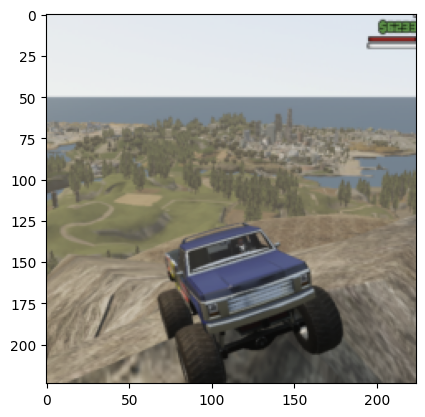

[CLS] a car is parked in the grass. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
example_generation('/content/checkpoints/Screenshot 2024-06-01 at 3.24.56 PM.png', model)

## Download the model and load model again

In [ ]:
model_path = '/content/image_caption_epoch_1.pth'
torch.save(model.state_dict(), model_path)

Load model again

In [ ]:
loaded_model = Captioner(vocab_size = tokenizer.vocab_size, max_length = 32, d_model = 512, num_heads = 8, dropout = 0.4)

In [ ]:
loaded_model.load_state_dict(torch.load('/content/image_caption_epoch_1.pth'))


<All keys matched successfully>

In [ ]:
loaded_model.eval()

Captioner(
  (seq_embedding): Embedding(
    (embedding): Embedding(30522, 512)
  )
  (decoder_layers): ModuleList(
    (0): DecoderLayer(
      (self_attention): CausalSelfAttention(
        (mha): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (cross_attention): CrossAttention(
        (mha): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (ff): FeedForward(
        (seq): ModuleList(
          (0): Linear(in_features=512, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=512, bias=True)
          (3): Dropout(p=0.4, inplace=False)
        )
        (layernorm): LayerNorm((512,), eps=1e-05, 

In [ ]:
loaded_model = loaded_model.to(device)

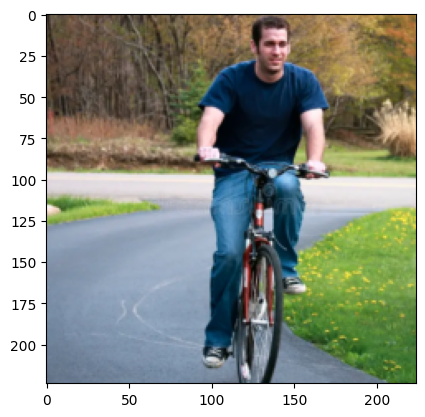

[CLS] a man riding a bike on a bike on a bike. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
example_generation('/content/Screenshot 2024-05-31 at 3.37.33 AM.png', loaded_model)